# Quantum Teleporation : Excerpt from IBM quantum learning - Basics of quantum informaiton - Entanglement in action
### For class 2025 spring "Introduction to quantum information and quantum computing" Seoul National University, Department of Physics and Astronomy Instructor: Dohun Kim 
### For maximizing students' Qiskit programming capability, we intentionally try to use the real backend even though sometimes running on a simulator is simpler. 

## Study material

Refer to the accompanied slides that I stole from IBM quantum learning. We mainly do Qiskit experience here (which is also a slight modification of what is given in IBM quantum learning). 

### Step 1: Creat and draw circuit for Quantum teleportation
We first check Qiskit version (1.3.2 should be ok), and then creat and draw circuit.

In [1]:
from qiskit import __version__
print(__version__)

1.4.0


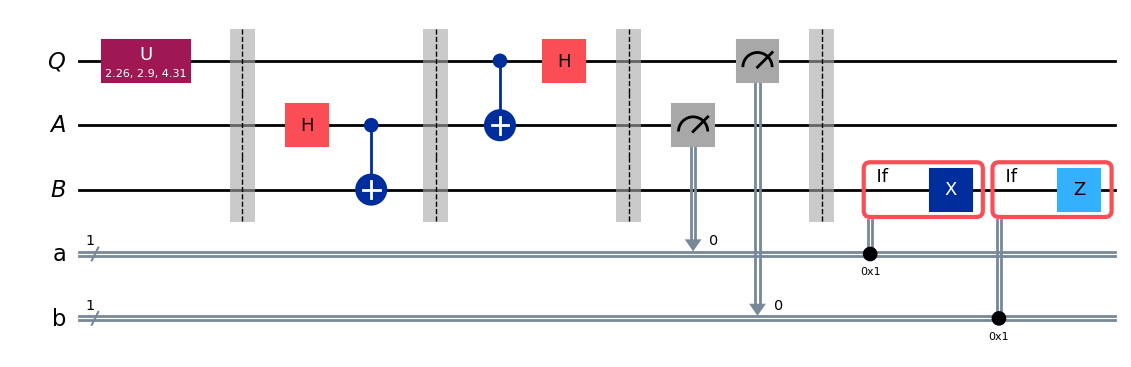

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")
random_gate = UGate(                   # We use a random unitary gate that is applied to the Alice's initially zero state.
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi
)

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare Alice's qubit before the protocol
protocol.append(random_gate,qubit)
protocol.barrier()

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

display(protocol.draw(output="mpl"))

### Some new features

The circuit makes use of a few features of Qiskit that we've not yet seen in previous lessons, including the 'barrier' and 'if_test' functions. The barrier function creates a visual separation making the circuit diagram more readable, and it also prevents Qiskit from performing various simplifications and optimizations across the barrier during compilation when circuits are run on real hardware. The if_test function applies an operation conditionally depending on a classical bit or register.

### Choose a proper backend
As always, we choose a proper backend satisfying the requirements. Also this time, we check if the selected backend supports dynamic circuit that is required for classically conditional operation. 

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import PassManager

token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend = service.least_busy(
    operational=True, min_num_qubits=protocol.num_qubits, simulator=False)
print(backend.name)

# local simulator of the backend
from qiskit_aer import AerSimulator
backend_sim = AerSimulator.from_backend(backend)

# returns True if backend supports dynamic circuits
"dynamic_circuits" in backend.configuration().supported_features

<IBMBackend('ibm_sherbrooke')>


True

### Full State tomography with real backend 

This part is different from IBM quantum learning. Using what we learned in the class, we do full three qubit state tomography of the final state after the teleporation protocol with real backend.

In [15]:
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography

# QST Experiment
qstexp1 = StateTomography(protocol)
qstdata1 = qstexp1.run(backend_sim, seed_simulation = 100).block_for_results()
# qstdata1 = qstexp1.run(backend, seed_simulation = 100).block_for_results()

# Print total results
for result in qstdata1.analysis_results():
    print(result)

AnalysisResult
- name: state
- value: DensityMatrix([[ 0.05107964+0.j        ,  0.00282118+0.00672743j,
                 0.00236003-0.00303819j,  0.00227865-0.00472005j,
                -0.07820638-0.01459418j,  0.00651042-0.00195313j,
                -0.00455729-0.00577799j, -0.00317383+0.00463867j],
               [ 0.00282118-0.00672743j,  0.06062826+0.j        ,
                 0.00358073-0.00358073j,  0.00154622-0.00271267j,
                -0.00455729+0.00488281j, -0.08455404-0.01719835j,
                 0.00415039+0.00756836j,  0.00472005+0.00642904j],
               [ 0.00236003+0.00303819j,  0.00358073+0.00358073j,
                 0.06892904+0.j        , -0.00059679-0.00694444j,
                -0.00260417+0.00056966j, -0.01000977-0.0090332j ,
                -0.08422852-0.01703559j,  0.00358073-0.0078125j ],
               [ 0.00227865+0.00472005j,  0.00154622+0.00271267j,
                -0.00059679+0.00694444j,  0.04852973+0.j        ,
                 0.00024414+0.00952

### Resultant density matrix

When successfully done, we can plot the full density matrix as follows. It is supposed to be messy. 

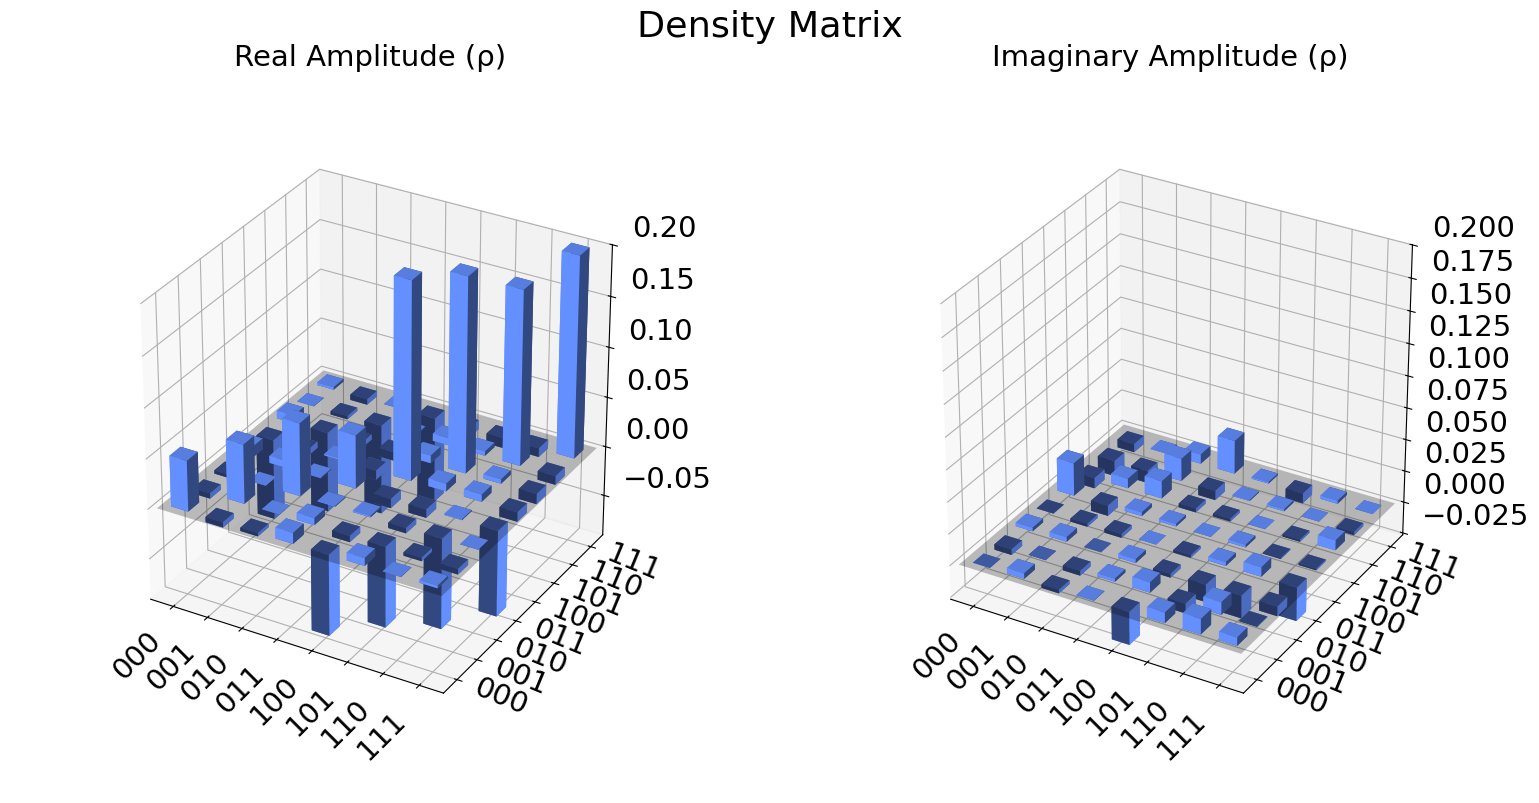

In [12]:
# Only obtain the density matrix
state_result = qstdata1.analysis_results("state")
# print(state_result.value)

# Visualize the density matrix above
from qiskit.visualization import plot_state_city
plot_state_city(qstdata1.analysis_results("state").value, title='Density Matrix')


### Check Bob's qubit state - Reduced density matrix

We also learned how to focus only on a subsystem. Let's see Bob's qubit only. Here is how we do this. Again, it should be messy because we have teleported Alice's randomly prepared state. 

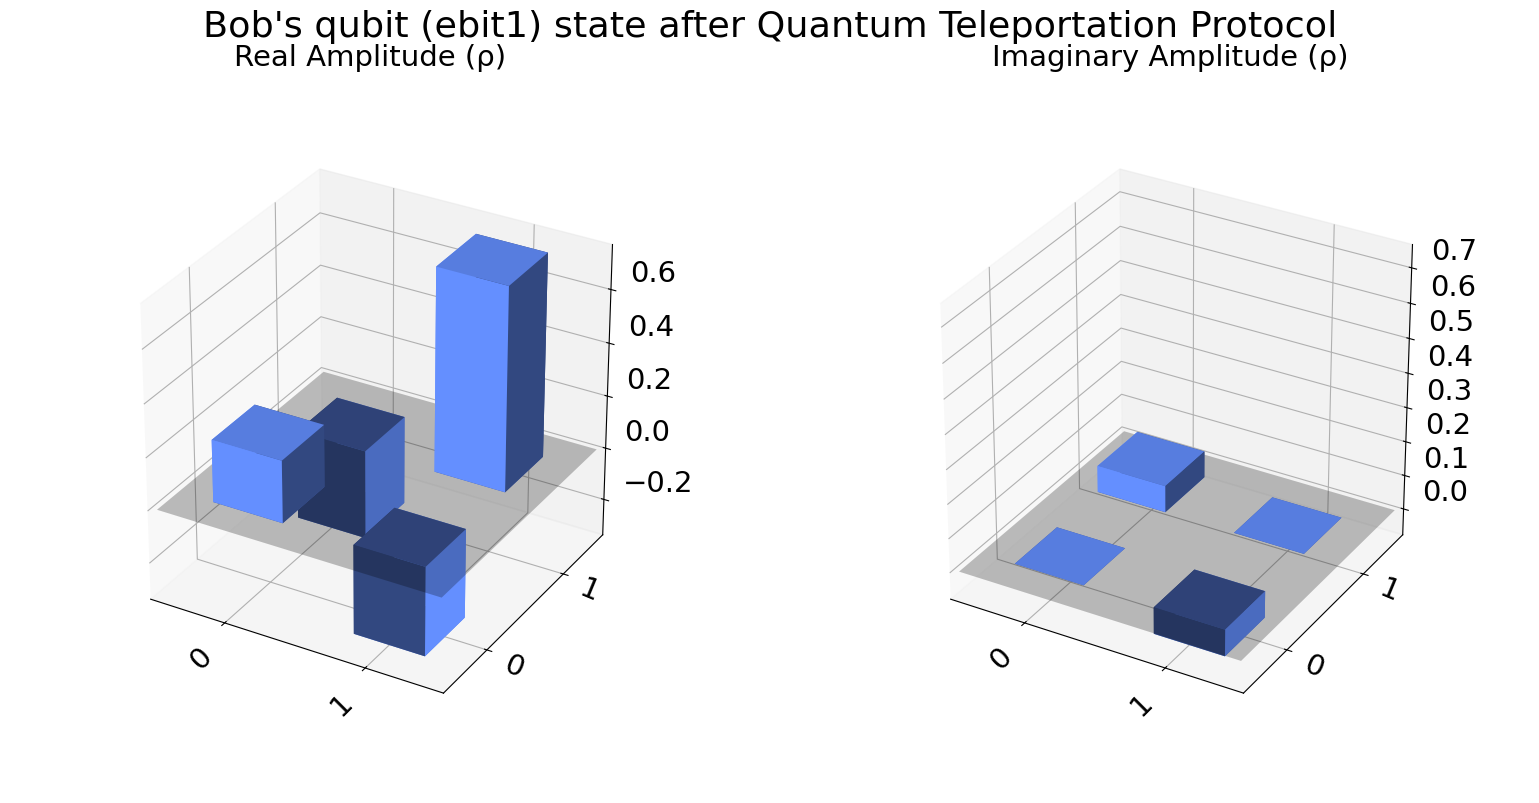

In [13]:
# Output the final state
from qiskit.quantum_info import partial_trace
Bobqstate = partial_trace(qstdata1.analysis_results("state").value, [0,1])
plot_state_city(Bobqstate, title="Bob's qubit (ebit1) state after Quantum Teleportation Protocol")


#### Fidelity check
Below is an example of calculating state fidelity of the Bob's teleported qubit with an ideal case (assuming that Alice has prepared $|+\rangle$ state).  

In [14]:
from qiskit.quantum_info import Statevector,state_fidelity
idqubit = QuantumRegister(1, "idQ")
iq=QuantumCircuit(idqubit)
iq.append(random_gate,idqubit)
sv=Statevector.from_label('0')
sv=sv.evolve(iq)
plot_state_city(sv)
print(state_fidelity(Bobqstate, sv))

0.9374920800344955


#### DIY:
<details>
<summary>
Check your self, by modifying the code, that reliable teleportation of an arbitrary qubit state is not possible without using entangled state. For example, can Alice send the qubit state to Bob if they share just classically correlated two bits ? 
<details>
<summary>
This example run the experiement on a actual quantum computer. Modify the code so that one can get results by simulator (Aer). 
<details>
<summary>
Also in this example, classical conditional operation on the Bob side is done. Replace that part with quantum two-qubit gate and see if the resultant state fidelity is overall higher or not. Discuss possible reasons why or why not there is difference.   
